# Import Libs

In [1]:
import tensorflow as tf ### models
import matplotlib.pylab as plt ### ploting 
import seaborn as sns
import numpy as np ### math computations
import tensorflow_datasets as tfds
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, InputLayer, BatchNormalization, Input, Layer
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import BinaryAccuracy, TruePositives, FalsePositives, FalseNegatives, TrueNegatives,Precision,Recall, AUC
from sklearn.metrics import confusion_matrix, roc_curve,f1_score

In [2]:
tf.__version__

'2.10.0'

# Load Malaria Dataset

In [3]:
dataset, dataset_info = tfds.load('malaria',with_info=True, as_supervised=True, shuffle_files = True, split = 'train')

In [4]:
tfds.__version__

'4.9.2'

# Data Split

In [5]:
TRANI_RATIO = 0.8
VAL_RATIO = 0.1
TEST_RATIO = 0.1

In [6]:
def splits(dataset, TRANI_RATIO, VAL_RATIO, TEST_RATIO):
    DATASET_SIZE = len(dataset)
    train_dataset = dataset.take(int(TRANI_RATIO*DATASET_SIZE))
    val_test__dataset = dataset.skip(int(TRANI_RATIO*DATASET_SIZE))
    val_dataset = val_test__dataset.take(int(VAL_RATIO*DATASET_SIZE))
    test_dataset = val_test__dataset.skip(int(VAL_RATIO*DATASET_SIZE))
    return train_dataset, val_dataset, test_dataset   
    

In [7]:
#dataset = tf.data.Dataset.range(20)
train_dataset, val_dataset, test_dataset = splits(dataset, TRANI_RATIO, VAL_RATIO, TEST_RATIO)
print(list(train_dataset.as_numpy_iterator())[:2])
print(list(val_dataset.as_numpy_iterator())[:2])
print(list(test_dataset.as_numpy_iterator())[:2])

[(array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8), 1), (array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
      

# Data Visualizing

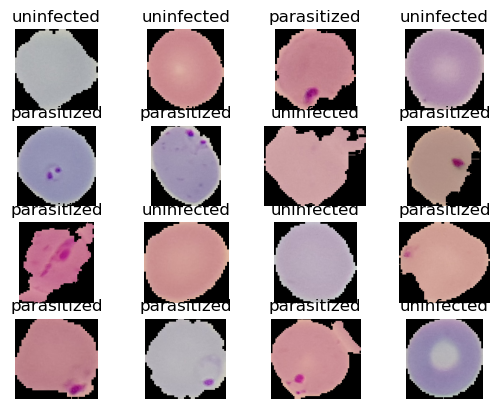

In [8]:
for i, (image, label) in enumerate(train_dataset.take(16)):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(image)
    plt.title(dataset_info.features['label'].int2str(label))
    plt.axis('off')

In [9]:
dataset_info.features['label'].int2str(0)

'parasitized'

# Data Preprocessing

In [10]:
IM_SIZE = 224
def resize_rescale(image, label):
    return tf.image.resize(image, (IM_SIZE, IM_SIZE))/255.0,label 

In [11]:
train_dataset = train_dataset.map(resize_rescale)
val_dataset = val_dataset.map(resize_rescale)
test_dataset = test_dataset.map(resize_rescale)

In [12]:
for image, label in train_dataset.take(1):
    print(image, label)

tf.Tensor(
[[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 ...

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]], shape=(224, 224, 3), dtype=float32) tf.Tensor(1, shape=(), dtype=int64)


In [13]:
train_dataset

<MapDataset element_spec=(TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [14]:
val_dataset

<MapDataset element_spec=(TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [15]:
BATCH_SIZE = 32
train_dataset = train_dataset.shuffle(buffer_size= 8 , reshuffle_each_iteration= True).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.shuffle(buffer_size= 8 , reshuffle_each_iteration= True).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Model Subclassing

In [16]:
class FeatureExtractor(Layer):
    def __init__(self, num_filters, kernel_size,num_strides, padding, activation_function, pool_size):
        super(FeatureExtractor, self).__init__()
        self.conv_1 = Conv2D(filters= num_filters,kernel_size=kernel_size, strides=num_strides, padding= padding, activation = activation_function)
        self.batch_1 = BatchNormalization()
        self.pool_1 = MaxPooling2D(pool_size=pool_size, strides=num_strides)
        
        self.conv_2 = Conv2D(filters= 2*num_filters,kernel_size=kernel_size, strides=num_strides, padding= padding, activation = activation_function)
        self.batch_2 = BatchNormalization()
        self.pool_2 = MaxPooling2D(pool_size=pool_size, strides=2*num_strides)
        
    def call(self, x, training):
        x = self.conv_1(x)
        x = self.batch_1(x)
        x = self.pool_1(x)
        
        
        x = self.conv_2(x)
        x = self.batch_2(x)
        x = self.pool_2(x)    
        
        return x

In [17]:
feature_sub_classed = FeatureExtractor(num_filters = 8, kernel_size = 3,num_strides = 1, padding= "valid", activation_function = "relu", pool_size = (2,2))

In [18]:
class LenetModel(Model):
    def __init__(self, num_filters, kernel_size,num_strides, padding, activation_function, pool_size, output_activation):
        super(LenetModel, self).__init__()
        
        self.featureExtractor = FeatureExtractor(
                                    num_filters = num_filters,
                                    kernel_size = kernel_size,
                                    num_strides = num_strides, 
                                    padding = padding, 
                                    activation_function = activation_function, 
                                    pool_size = pool_size)
        self.flatten = Flatten()
        
        self.dense_1 = Dense(units = 100, activation=activation_function)
        self.batch_1 = BatchNormalization()

        self.dense_2 = Dense(units = 10, activation=activation_function)
        self.batch_2 = BatchNormalization()

        self.dense_3 = Dense(units=1, activation = output_activation)
        
    def call(self, x, training):
        x = self.featureExtractor(x)
        x = self.flatten(x)

        x = self.dense_1(x)
        x = self.batch_1(x)
        
        
        x = self.dense_2(x)
        x = self.batch_2(x)
        
        x = self.dense_3(x)    
        
        return x

In [19]:
lenet_model = LenetModel(num_filters = 8, kernel_size = 3,num_strides = 1, padding= "valid", activation_function = "relu", pool_size = (2,2), output_activation = "sigmoid")
lenet_model(Input(shape= (IM_SIZE, IM_SIZE,3)))
lenet_model.summary()

Model: "lenet_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extractor_1 (Featur  multiple                 1488      
 eExtractor)                                                     
                                                                 
 flatten (Flatten)           multiple                  0         
                                                                 
 dense (Dense)               multiple                  19009700  
                                                                 
 batch_normalization_4 (Batc  multiple                 400       
 hNormalization)                                                 
                                                                 
 dense_1 (Dense)             multiple                  1010      
                                                                 
 batch_normalization_5 (Batc  multiple                 

# Optimizers

In [20]:
metrics = [TruePositives(name='tp'), FalsePositives(name= 'fp'), FalseNegatives(name= 'fn'), TrueNegatives(name='tn'),
          BinaryAccuracy(name='accuracy'), Precision(name='precision'), Recall(name='recall'), AUC(name='auc')]

In [21]:
lenet_model.compile(optimizer=Adam(learning_rate=0.1), loss=BinaryCrossentropy(), metrics= metrics)

# Train

In [22]:
history = lenet_model.fit(train_dataset, validation_data=val_dataset, epochs = 50, verbose=1)

Epoch 1/50
689/689 [==============================] - 23s 25ms/step - loss: 0.4113 - tp: 9751.0000 - fp: 2624.0000 - fn: 1275.0000 - tn: 8396.0000 - accuracy: 0.8231 - precision: 0.7880 - recall: 0.8844 - auc: 0.8955 - val_loss: 0.8260 - val_tp: 2.0000 - val_fp: 2.0000 - val_fn: 1390.0000 - val_tn: 1361.0000 - val_accuracy: 0.4947 - val_precision: 0.5000 - val_recall: 0.0014 - val_auc: 0.9596
Epoch 2/50
689/689 [==============================] - 17s 24ms/step - loss: 0.2978 - tp: 10592.0000 - fp: 1739.0000 - fn: 433.0000 - tn: 9282.0000 - accuracy: 0.9015 - precision: 0.8590 - recall: 0.9607 - auc: 0.9389 - val_loss: 1.4488 - val_tp: 1.0000 - val_fp: 0.0000e+00 - val_fn: 1375.0000 - val_tn: 1379.0000 - val_accuracy: 0.5009 - val_precision: 1.0000 - val_recall: 7.2674e-04 - val_auc: 0.9167
Epoch 3/50
689/689 [==============================] - 16s 24ms/step - loss: 0.3102 - tp: 10575.0000 - fp: 2000.0000 - fn: 448.0000 - tn: 9023.0000 - accuracy: 0.8890 - precision: 0.8410 - recall: 0.95

Epoch 42/50
689/689 [==============================] - 15s 22ms/step - loss: 0.1445 - tp: 10677.0000 - fp: 719.0000 - fn: 349.0000 - tn: 10301.0000 - accuracy: 0.9516 - precision: 0.9369 - recall: 0.9683 - auc: 0.9852 - val_loss: 4.7116 - val_tp: 1396.0000 - val_fp: 1356.0000 - val_fn: 1.0000 - val_tn: 2.0000 - val_accuracy: 0.5074 - val_precision: 0.5073 - val_recall: 0.9993 - val_auc: 0.5761
Epoch 43/50
689/689 [==============================] - 15s 22ms/step - loss: 0.1403 - tp: 10693.0000 - fp: 690.0000 - fn: 329.0000 - tn: 10334.0000 - accuracy: 0.9538 - precision: 0.9394 - recall: 0.9702 - auc: 0.9861 - val_loss: 5.3703 - val_tp: 1391.0000 - val_fp: 1352.0000 - val_fn: 1.0000 - val_tn: 11.0000 - val_accuracy: 0.5089 - val_precision: 0.5071 - val_recall: 0.9993 - val_auc: 0.5622
Epoch 44/50
689/689 [==============================] - 16s 23ms/step - loss: 0.1781 - tp: 10586.0000 - fp: 805.0000 - fn: 441.0000 - tn: 10214.0000 - accuracy: 0.9435 - precision: 0.9293 - recall: 0.9600 -

# Loss

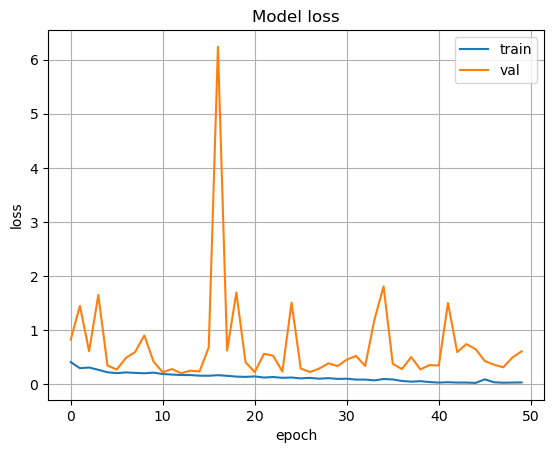

In [23]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','val'])
plt.grid(True)
plt.show()

# Performance

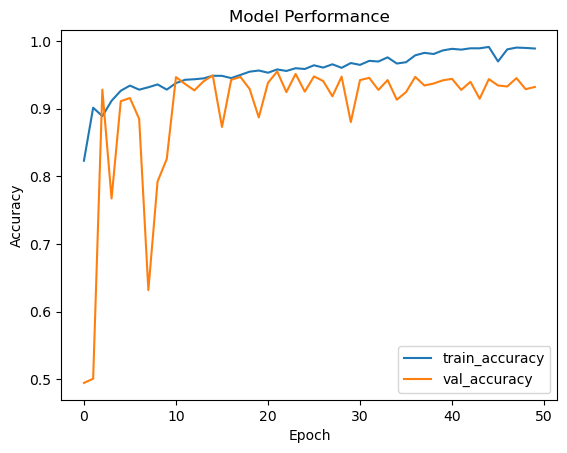

In [24]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Performance')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()

# Model Evaluation and Testing

In [25]:
test_dataset

<MapDataset element_spec=(TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [26]:
test_dataset = test_dataset.batch(1)
test_dataset

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [27]:
evals = lenet_model.evaluate(test_dataset, return_dict = True)
evals

2757/2757 [==============================] - 8s 3ms/step - loss: 0.4972 - tp: 1269.0000 - fp: 103.0000 - fn: 100.0000 - tn: 1285.0000 - accuracy: 0.9264 - precision: 0.9249 - recall: 0.9270 - auc: 0.9556


{'loss': 0.49716177582740784,
 'tp': 1269.0,
 'fp': 103.0,
 'fn': 100.0,
 'tn': 1285.0,
 'accuracy': 0.9263692498207092,
 'precision': 0.9249271154403687,
 'recall': 0.9269539713859558,
 'auc': 0.9555580615997314}

# Predict

In [28]:
lenet_model.predict(test_dataset.take(1))[0][0]

1/1 [==============================] - 1s 545ms/step


0.9999337

In [29]:
def parasite_or_not(x):
    if x<0.5:
        return str('P')
    else:
        return str('U')

In [30]:
parasite_or_not(lenet_model.predict(test_dataset.take(1))[0][0])

1/1 [==============================] - 1s 509ms/step


'U'

1/1 [==============================] - 0s 16ms/step


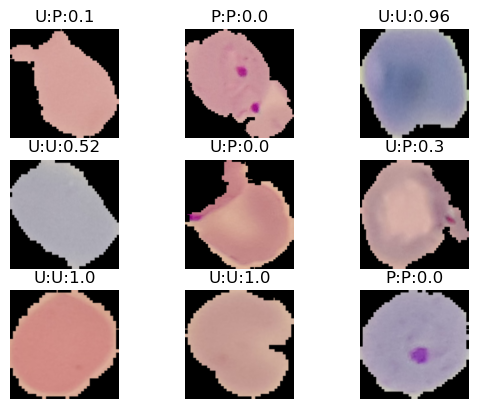

In [31]:
for i, (image, label) in enumerate(test_dataset.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image[0])
    res = lenet_model.predict(image)[0][0]
    plt.title(str(parasite_or_not(label.numpy()[0])) + ":" + str(parasite_or_not(res)) + ":"+ str(round(res, 2)))
    plt.axis('off')

# Visualising Confusion Matrix

In [32]:
inps = []
labels = []
for x,y in test_dataset.as_numpy_iterator():
    labels.append(y)
    inps.append(x)

In [33]:
labels[:5]

[array([0], dtype=int64),
 array([1], dtype=int64),
 array([0], dtype=int64),
 array([0], dtype=int64),
 array([0], dtype=int64)]

In [34]:
labels = np.array([i[0] for i in labels])
print(labels)

[0 1 0 ... 1 1 0]


In [35]:
predicted = lenet_model.predict(np.array(inps)[:,0,...])
predicted.shape

87/87 [==============================] - 1s 5ms/step


(2757, 1)

In [36]:
predicted[:, 0]

array([1.79776180e-04, 9.99197066e-01, 1.96599381e-09, ...,
       9.99998927e-01, 9.99973297e-01, 1.25046406e-11], dtype=float32)

In [37]:
predicted = predicted.squeeze()
predicted.shape

(2757,)

In [38]:
threshold = 0.5

cm = confusion_matrix(labels, predicted > threshold)
print(cm)

[[1287  102]
 [ 101 1267]]


In [39]:
print(cm)

[[1287  102]
 [ 101 1267]]


Text(0.5, 58.7222222222222, 'Predicted')

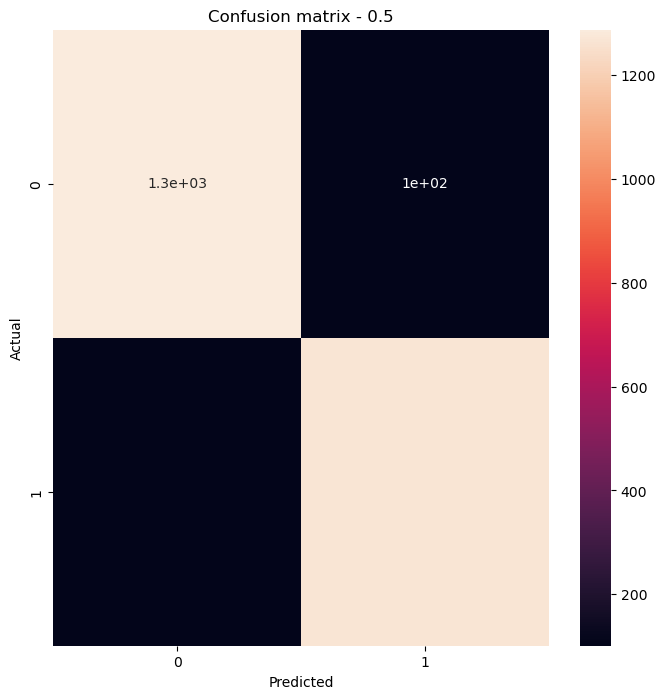

In [40]:
plt.figure(figsize = (8, 8))
sns.heatmap(cm, annot=True)
plt.title('Confusion matrix - {}'.format(threshold))
plt.ylabel('Actual')
plt.xlabel('Predicted')

# ROC Plots

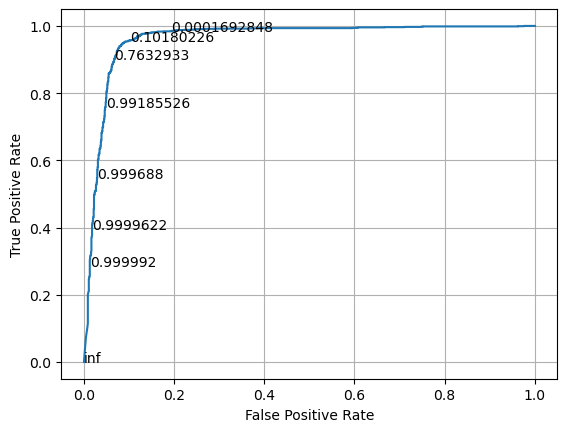

In [41]:
fp, tp ,threshoulds = roc_curve(labels, predicted)
plt.plot(fp, tp)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.grid()

skip = 50

for i in range(0, len(threshoulds), skip):
    plt.text(fp[i], tp[i], threshoulds[i])
plt.show()

In [42]:
f1 = f1_score(y_true= labels, y_pred= np.round(predicted))
f1

0.9258312020460359